# Model comparison

In this lesson, we focus on the metrics commonly used _in practice_ to compare models. The previous lesson should help you understand why these metrics are good ones to use. Note that these are not the “best” metrics in any mathematically optimal sense. They are metrics that have stood the test of time after many researchers have applied them to many practical problems.

## Prep plan

* The McElreath reading should take ~1 hour. Spend the rest of your time on the exercises at the end of this workbook.
* You will find the Python-translated code from the textbook here, as usual.
* There is some code cells that take a while time to run. Click “Run All” now so it can complete while you are reading.
* See the _Exercises_ section at the end of the workbook — there are 2 required exercises, but they are both long exercises.
* [🤖 CS146 AI assistant](https://gemini.google.com/gem/16q5NXF2p2xK4_ghP0sE-a-VugUan_Dvy?usp=sharing)


## Required reading: Statistical rethinking

Read Section 7.3 and 7.4 of McElreath, R. (2020). _Statistical Rethinking, Second Edition_. Chapman and Hall/CRC Press.

* [Publisher’s page](https://www.routledge.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-STAN/McElreath/p/book/9780367139919) for buying the book if you want to
* [The whole book is available online on O’Reilly via the San Francisco Public Library](https://learning-oreilly-com.ezproxy.sfpl.org/library/view/statistical-rethinking-2nd/9780429639142/xhtml/15_Chapter07.xhtml). Log in with your library card number.

Outline:
* **Section 7.3 (_Golem taming_) is required** (1170 words). This section explains regularizing priors and how they help avoid overfitting.
* **Section 7.4 (_Predicting predictive accuracy_) is required** (4410 words). We look at cross-validation and a few information criteria for comparing the predictive quality of models. You will see a lot of difference “information criteria” used here. The ones that are used the most in practice (and in class) are WAIC (_widely applicable information criterion_) and PSIS (_Pareto-smoothed importance sampling_) so focus on those rather than AIC, BIC, and DIC.

The next part of this workbook contains the R code provided in the McElreath book, translated to Python and PyMC. The code was modified and cleaned up slightly from [the source](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_07.ipynb) (the `pymc-resources` repository). While reading Section 7.4, you need to follow along in this workbook and run the code as you go.

## Code from Section 7.4

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as sts
from scipy.special import logsumexp

#### Code 7.19: Fit model to cars data

In [ ]:
# Load cars data
data = pd.read_csv(
    'https://course-resources.minerva.edu/uploaded_files/mu/00265536-6949/car.csv',
    sep=',', index_col=0)

In [ ]:
with pm.Model() as m:
    a = pm.Normal('a', mu=0, sigma=100)
    b = pm.Normal('b', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', 0, 30)
    mu = pm.Deterministic('mu', a + b * data['speed'])
    dist = pm.Normal('dist', mu=mu, sigma=sigma, observed=data['dist'])
    m_inference = pm.sample(chains=4)
az.summary(m_inference, var_names="~mu")

#### Code 7.20: Log-likelihood of each observation

Note: The textbook shows how to compute these values manually. In PyMC, we can add the log likelihood values to the inference object using the `compute_log_likelihood()` function.

In [ ]:
# The ... notation below in transpose() means "reorder the axes so that 'sample'
# is the first axis and then the other axes appear in the same order as before.
m_posterior = m_inference.posterior.stack(sample=('chain', 'draw')).transpose('sample', ...)

n_samples = m_posterior.sample.shape[0]
n_cases = data.shape[0]
logprob = np.zeros((n_cases, n_samples))

for s in range(n_samples):
    p_ = sts.norm.logpdf(
        data['dist'],
        loc=m_posterior.mu[s],
        scale=m_posterior.sigma[s])
    logprob[:, s] = p_

#### Code 7.21: Compute the LPPD of each datum

In [ ]:
lppd = np.zeros(n_cases)
for a in range(n_cases):
    lppd[a] = logsumexp(logprob[a]) - np.log(n_samples)

#### Code 7.22: Compute the WAIC contribution of each datum

In [ ]:
pWAIC = np.zeros(n_cases)
for i in range(n_cases):
    pWAIC[i] = np.var(logprob[i])

#### Code 7.23: Compute the WAIC

In [ ]:
print(-2 * (sum(lppd) - sum(pWAIC)))

#### Code 7.24: Compute the WAIC standard error

In [ ]:
waic_vec = -2 * (lppd - pWAIC)
print((n_cases * np.var(waic_vec)) ** 0.5)

**Note:** Now that you know how WAIC is computed, you can use `arviz.waic` to compute the results for you. The code cell below produces the same WAIC and standard error results as the two code cells above. The `scale='deviance'` argument is necessary to scale the WAIC by a factor of −2 to match the definition of deviance. By default, PyMC does _not_ scale by −2.

In [ ]:
with m:
    pm.compute_log_likelihood(m_inference)
az.waic(m_inference, scale='deviance')

## Exercises

Solve all these exercises before class. These exercises are challenging but there are only two of them. Work hard to solve each of them. We will discuss your results and questions in class.

### McElreath Exercise 7H1

In 2007, _The Wall Street Journal_ published an editorial (“We’re Number One, Alas”) with a graph of corporate tax rates in 29 countries plotted against tax revenue. A badly fit curve was drawn in (see below), seemingly by hand, to make the argument that the relationship between tax rate and tax revenue increases and then declines, such that higher tax rates can actually produce less tax revenue. I want you to actually fit a curve to these data, found in `data(Laffer)`. Consider models that use tax rate to predict tax revenue. Compare, using WAIC or PSIS, a straight-line model to any curved models you like. What do you conclude about the relationship between tax rate and tax revenue?

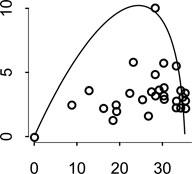

**Steps:**
1. Standardize the data.
1. Fit linear, quadratic, and cubic models using normally distributed noise.
1. Compare the three models using PSIS and WAIC.

**Hints:**

* You can compute PSIS and WAIC using `arviz.loo(inference)` and `arviz.waic(inference)`, respectively.
* In the output from these functions, “ELPD” is “expected log pointwise predictive density” which is the same thing McElreath calls “LPPD”.
* Use `arviz.compare({'name 1': inference_1, 'name 2': inference_2}, ic='loo')` to compare two models (or more if you add more entries in the dictionary) using PSIS. Replace `'loo'` with `'waic'` to use WAIC instead.
* Use `arviz.plot_compare(comparison)` where `comparison` is the output from the `arviz.compare` function to visualize the model comparison results. To make these plots look exactly like the ones in the textbook, you should use `az.plot_compare(comparison, plot_ic_diff=True, insample_dev=True, legend=True)`.

In [ ]:
# Data originally sourced from https://github.com/rmcelreath/rethinking
data = pd.read_csv(
    'https://course-resources.minerva.edu/uploaded_files/mu/00265537-6551/laffer.csv',
    sep=';')

# Plot the data
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.title('Data')
plt.xlabel('tax rate')
plt.ylabel('tax revenue')
plt.scatter(data['tax_rate'], data['tax_revenue'])
plt.show()

# YOUR WORK GOES HERE
# PASTE YOUR CODE INTO FORUM, INCLUDE YOUR CONCLUSIONS IN THE CODE COMMENTS

### McElreath Exercise 7H2

In the `Laffer` data (the same as in the previous exercise), there is one country with a high tax revenue that is an outlier.

1. Use PSIS and WAIC to measure the importance of this outlier in the models you fit in the previous problem.
2. Then, use robust regression with a Student’s T distribution to revisit the curve fitting problem. How much does a curved relationship depend upon the outlier point?
3. Use model comparison to determine whether using a Normal distribution or a T distribution provides a better fit.

**Hints:**

* Use `arviz.loo(inference, pointwise=True).loo_i` to get the PSIS (or WAIC if you use `arviz.waic`) values for each data point.

In [ ]:
# PASTE YOUR CODE INTO FORUM, INCLUDE YOUR CONCLUSIONS IN THE CODE COMMENTS